In [1]:
%load_ext autoreload

%autoreload 2

from __future__ import division, print_function

import cPickle as pickle
from glob import glob
import subprocess
import sys
import string
import os
import random
import numpy as np
from os.path import join
%matplotlib inline
import matplotlib
matplotlib.rc("figure", dpi=144)
import matplotlib.pyplot as plt

import threebody

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

In [2]:
#name = "heavysimple"
#name = "dailyDM"
name = "primary"


In [3]:
d = join("derivative-runs",name)
params = pickle.load(open(join(d,"params.pickle"),"rb"))
F = threebody.Fitter(**params)
try:
    F.best_parameters = pickle.load(
        open(join(d,"best_parameters.pickle"),"rb"))
except IOError:
    pass
derivatives = {}
for p in F.parameters:
    derivatives[p] = np.load(join(d,"%s.npy" % p))
print("Goodness of fit:",F.goodness_of_fit())
M, linear_parameters = F.compute_linear_matrix()
lv, linear_parameters = F.compute_linear_parts()
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

ps = F.parameters + linear_parameters
Abig = np.array([derivatives[p] 
                 for p in ps], 
                dtype=np.longdouble).T
#print(Abig.shape)
result = threebody.lstsq_with_errors(Abig, 
                                     F.residuals(), 
                                     F.phase_uncerts)

for i,p in enumerate(ps):
    if p in F.parameters:
        v = F.best_parameters[p]
    elif p in linear_parameters:
        v = lv[linear_parameters.index(p)]
    else:
        v = 0
    print(p, 
          threebody.fmt(v-result.x[i], result.uncerts[i]), 
          result.uncerts[i])

Goodness of fit: 36705.6440017
asini_i 1.2175253(3)e0 2.6926015548e-07
pb_i 1.6293936(7)e0 6.92224085412e-07
eps1_i 6.882(2)e-4 2.09183776441e-07
eps2_i -9.1386(18)e-5 1.82778303578e-08
tasc_i 4.0771665(7)e-1 6.67232701079e-08
acosi_i 1.48960(19)e0 0.000185960969016
q_i 1.37405(4)e-1 4.2872942492e-06
asini_o 7.4672637(13)e1 1.29374583042e-05
pb_o 3.2725692(11)e2 0.000112698196273
eps1_o 3.518598(5)e-2 4.94105831208e-08
eps2_o -3.46302(16)e-3 1.64350797726e-07
tasc_o 3.1393519(11)e2 0.000112652071235
acosi_o 9.1363(12)e1 0.0121138394708
delta_lan 2.2(8)e-6 7.76636742337e-07
delta -1.02(19)e-6 1.91005168492e-07
dgamma 1(3)e-2 0.0267434929162
dbeta 2(5)e-2 0.0516104266836
DM_0001 -2.29(8)e-1 0.00813233946468
DM_0002 -1.65(10)e-1 0.00972564704323
DM_0003 -9.8(11)e-2 0.0105612289264
DM_0004 -6.8(9)e-2 0.00865533759509
FD1 2.0(13)e-3 0.00130073393192
FD2 0(6)e-3 0.00584639895926
FD3 0(11)e-3 0.0110620559036
FD4 8(8)e-3 0.00750363855402
IPM_0000 9.6(6)e1 6.41606993113
IPM_0001 6.2(17)e1 16.91

In [51]:
# FIXME
bp = F.best_parameters.copy()
for p in F.parameters:
    i = ps.index(p)
    bp[p] -= result.x[i]
pre = F.goodness_of_fit(F.best_parameters)
print("pre-improvement:", pre)
post = F.goodness_of_fit(bp)
print("post-improvement:", post)
if post<pre:
    with open("derivative-best-parameters.pickle","wb") as f:
        pickle.dump(bp, f)

pre-improvement: 34475.6564269
post-improvement: 3544274.94456


In [52]:
F.parameters

['asini_i',
 'pb_i',
 'eps1_i',
 'eps2_i',
 'tasc_i',
 'acosi_i',
 'q_i',
 'asini_o',
 'pb_o',
 'eps1_o',
 'eps2_o',
 'tasc_o',
 'acosi_o',
 'delta_lan',
 'delta',
 'dgamma',
 'dbeta']

In [53]:
np.median(F.phase_uncerts)/F.reference_f0*1e6

1.24043120876

In [54]:
dir(result)

['__doc__',
 '__module__',
 'chi2',
 'corr',
 'cov',
 'reduced_chi2',
 'residuals',
 'residuals_scaled',
 'singular_values',
 'uncerts',
 'x']

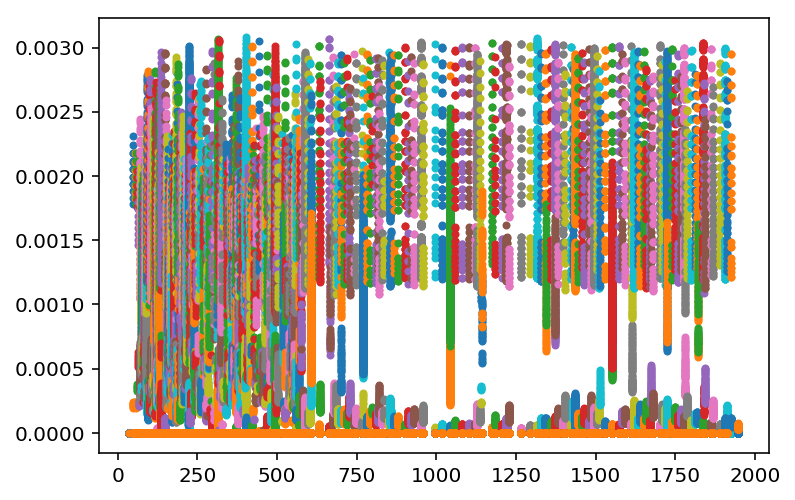

In [55]:
i = 1
while True:
    dmn = "DM_%04d" % i
    if dmn not in derivatives:
        break
    plt.plot(F.mjds, derivatives[dmn], ".")
    i += 1

384 383


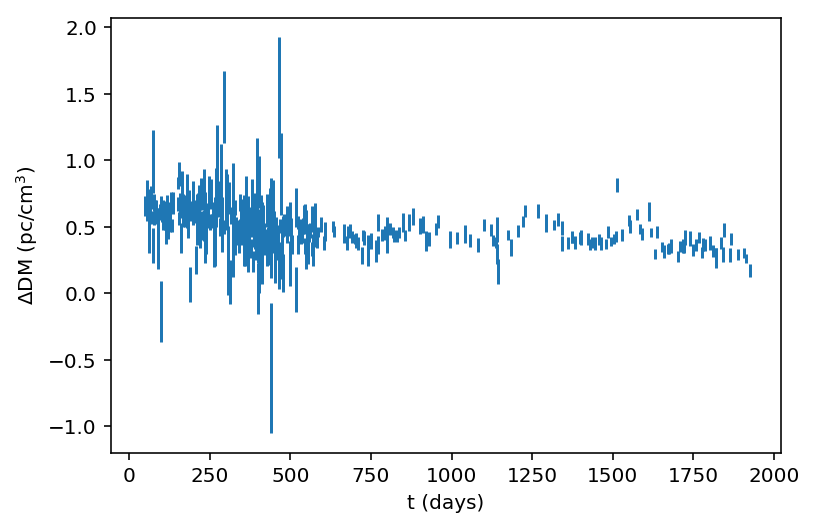

In [59]:
epochs = F.dmx_epochs
dms = [0]
dmus = [0]
i = 1
while True:
    dmn = "DM_%04d" % i
    if dmn not in derivatives:
        break
    ix = ps.index(dmn)
    ix2 = linear_parameters.index(dmn)
    dms.append(lv[ix2] - result.x[ix])
    dmus.append(result.uncerts[ix])
    i += 1
print(len(epochs),len(dms))
epochs = epochs[:len(dms)]
plt.errorbar(epochs, dms, dmus, linestyle="none")
plt.xlabel("t (days)")
plt.ylabel("$\Delta$DM (pc/cm$^3$)")
plt.savefig("delta-dm.pdf")

In [ ]:
i = 0
while True:
    ipmn = "IPM_%04d" % i
    if ipmn not in derivatives:
        break
    plt.plot(F.mjds, derivatives[ipmn], ".")
    i += 1

In [ ]:
epochs = F.dmx_epochs
ipms = []
ipmus = []
i = 0
while True:
    ipmn = "IPM_%04d" % i
    if ipmn not in derivatives:
        break
    ix = ps.index(ipmn)
    ix2 = linear_parameters.index(ipmn)
    ipms.append(lv[ix2]-result.x[ix])
    ipmus.append(result.uncerts[ix])
    i += 1
ipms = np.array(ipms)
ipmus = np.array(ipmus)
f = 1/F.reference_f0
plt.errorbar(epochs, (f*ipms+1)*10, f*ipmus*10, linestyle="none")
#plt.errorbar(epochs, ipms, ipmus, linestyle="none")
plt.axhline(10,linestyle=":", color="gray")
plt.xlabel("t (days)")
plt.ylabel("$n_e$ at 1 AU (cm$^{-3}$)")

In [ ]:
ips = ["DM_0001", "FD1", "FD2", "FD3", "FD4", "IPM_0001"]
M = np.zeros((len(ips),len(ips)))
for i,p in enumerate(ips):
    ii = ps.index(p)
    for j,q in enumerate(ips):
        jj = ps.index(q)
        M[i,j] = result.corr[ii,jj]
M